In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs.visuals import vis
from libs import helpers

Available LLMs: (24): llama-3.1-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
APS_OA_DATA_TAR_GZ = '../../../GTBuilder/APS/data/final_dataset.tar.gz'
APS_OS_DISCIPLINE_DEMOGRAPHICS = '../../results/ground_truth/metadata/disciplines_author_demographics.csv'


In [4]:

RESULTS_PATH = '../../results/ground_truth'
PLOTS_PATH = io.path_join(RESULTS_PATH, 'plots')    

io.validate_path(PLOTS_PATH)

In [5]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

## Data

In [6]:
# demographics
df_all_authors_demographics = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_DEMOGRAPHICS_FN)
df_all_authors_demographics.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# scholarly stats
df_all_authors_stats = io.read_file_from_tar_gz_as_dataframe(APS_OA_DATA_TAR_GZ, constants.APS_OA_AUTHORS_STATS_FN)
df_all_authors_stats.rename(columns={'id_author':'id_author_oa'}, inplace=True)

# per discipline
df_gt_stats = io.read_csv(APS_OS_DISCIPLINE_DEMOGRAPHICS, index_col=0, header=[0, 1])

# gt (from APS)
df_gt = df_all_authors_demographics[['id_author_oa','first_name','last_name','ethnicity','gender']].copy()
df_gt = df_gt.merge(df_all_authors_stats[['id_author_oa','works_count','cited_by_count', 'rr1_rank_publications','rr1_rank_publications_percentile', 'rr2_rank_citations','rr2_rank_citations_percentile']], on='id_author_oa', how='left')
df_gt = helpers.add_quantiles(df_gt)

# shapes
df_all_authors_demographics.shape, df_gt_stats.shape, df_gt_stats.shape, df_gt.shape

((481012, 14), (17, 19), (17, 19), (481012, 13))

## Stats

In [7]:
df_gt.gender.value_counts(normalize=True) * 100

gender
Male       44.432779
Unknown    42.221192
Female      8.772130
Unisex      4.573898
Name: proportion, dtype: float64

In [8]:
df_gt.ethnicity.value_counts(normalize=True) * 100

ethnicity
Asian                        44.591819
White                        38.731882
Hispanic or Latino            8.247195
Black or African American     6.055982
Unknown                       2.373122
Name: proportion, dtype: float64

# Plots

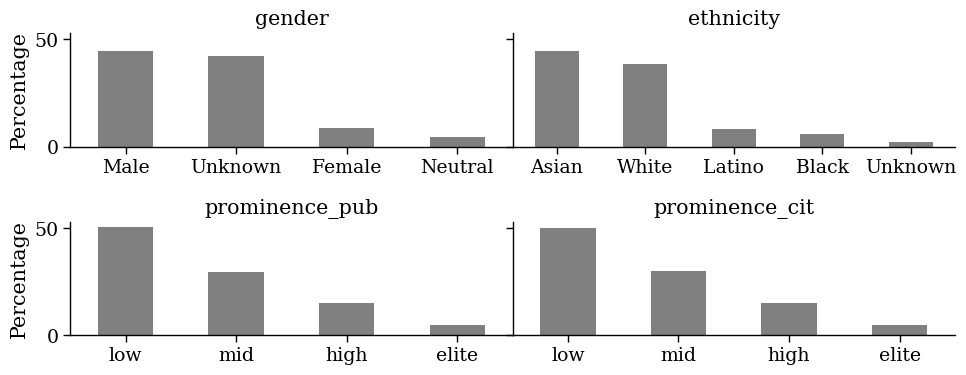

In [9]:
df_gender = df_gt.copy()
df_gender.gender = df_gender.gender.replace({'Unisex': 'Neutral'})
df_gender = df_gender.gender.value_counts(normalize=True) * 100
df_ethnicity = df_gt.ethnicity.value_counts(normalize=True) * 100
df_prominence_pub = df_gt.prominence_pub.value_counts(normalize=True) * 100
df_prominence_cit = df_gt.prominence_cit.value_counts(normalize=True) * 100

set2 = vis.plt.get_cmap("Set2")
colors_gender = [set2(i) for i in range(3)] + [set2(7)]
colors_ethnicity = [set2(i) for i in range(3,7)] + [set2(7)]
pas1 = vis.plt.get_cmap("Pastel1")
colors_prominence = [pas1(i) for i in range(4)]

fig, (ax1, ax2) = vis.plt.subplots(2, 2, figsize=(10, 4), sharey=True)
for attr, ax, df in zip(['gender', 'ethnicity', 'prominence_pub', 'prominence_cit'], [ax1[0], ax1[1], ax2[0], ax2[1]], [df_gender, df_ethnicity, df_prominence_pub, df_prominence_cit]):
    ax = df.plot(kind='bar', ax=ax, 
                color = 'grey'
                # color=colors_gender if attr == 'gender' else colors_ethnicity if attr == 'ethnicity' else colors_prominence
                )
    ax.set_title(attr)
    ax.set_xlabel('')
    ax.set_ylabel('Percentage')
    xticks = df.index if attr == 'gender' else [constants.ETHNICITY_SHORT_DICT[i] for i in df.index] if attr == 'ethnicity' else ax.get_xticklabels()
    ax.set_xticklabels(xticks, rotation=0)

vis.plt.tight_layout()
vis.plt.subplots_adjust(wspace=0.)

fn = io.path_join(PLOTS_PATH, 'percentage_demographics.pdf')
if fn is not None:
    fig.savefig(fn, bbox_inches='tight', dpi=constants.FIG_DPI)

vis.plt.show()
vis.plt.close()
